In [46]:
import pandas as pd
import os
import numpy as np
import torch as t
import matplotlib.pylab as pl

In [47]:
TRAINING_PATH = './crime-train.txt'
TEST_PATH = './crime-test.txt'
df_train = pd.read_table(TRAINING_PATH)
df_test = pd.read_table(TEST_PATH)
feature_book = list(df_train)[1:]
print df_train.head()
print df_test.head()

   ViolentCrimesPerPop  population  householdsize  agePct12t21  agePct12t29  \
0                 0.67       -0.45          -1.85        -1.06         0.67   
1                 0.43       -0.45          -0.27        -0.22        -0.17   
2                 0.12       -0.14           1.87         0.55         0.04   
3                 0.03       -0.38           0.53        -0.28        -0.79   
4                 0.14       -0.30          -1.12        -0.74        -0.10   

   agePct16t24  agePct65up  numbUrban  pctUrban  medIncome  \
0         0.08       -0.85      -0.34      0.68      -0.24   
1        -0.34       -0.58      -0.50     -1.57      -0.29   
2         0.02       -1.19      -0.03      0.68       1.05   
3        -0.64       -0.35      -0.34      0.46       0.66   
4        -0.40       -0.30      -0.19      0.68       0.76   

          ...           NumStreet  PctForeignBorn  PctBornSameState  \
0         ...               -0.23           -0.02             -0.53   
1         

In [48]:
y_train, X_train = df_train.values[:,0].reshape(-1,1), df_train.values[:,1:]
y_test, X_test = df_test.values[:,0].reshape(-1,1), df_test.values[:,1:]
print 'load training data:\n X_train: {}\n y_train: {}'.format(
    X_train.shape, y_train.shape)
print 'load test data:\n X_test: {}\n y_test: {}'.format(
    X_test.shape, y_test.shape)

load training data:
 X_train: (1595, 95)
 y_train: (1595, 1)
load test data:
 X_test: (399, 95)
 y_test: (399, 1)


In [49]:
# add one col as bias
X_train = np.hstack((np.ones(X_train.shape[0]).reshape(-1,1), X_train))
X_test = np.hstack((np.ones(X_test.shape[0]).reshape(-1,1), X_test))
print X_train.shape, X_test.shape

(1595, 96) (399, 96)


In [50]:
def loss_gradient(X, y, W, reg, Is_train=True):
    '''Input: 
            X: training data, shape is (N, D+1), the extra one dimenstion is use to add bias, all equal to 1
            y: training data, shape is (N, 1)
            W: weight, shape is (D+1, 1), the extra one dimenstion is bias b
            reg: L2 regularization strength, is a hyperparameter
            Is_train: get loss without regularization 
       Output:
            loss: scala
            dW: shape as W
    '''
    N, D = X.shape
    y_pred = X.dot(W)
    loss = 0.5 * np.sum((y - y_pred)**2)
    if Is_train == True:
        loss += reg * np.sum(W**2)
        dW = -X.T.dot(y - y_pred) 
        dW += 2 * reg * W
        return loss, dW
    else:
        return loss

def train_LS(X, y, W, learning_rate, reg, num_iters, stop, batch_size, verbose=False):
    N, D = X.shape
    if W is None:
        # initialize W
        W = 0.001 * np.random.randn(D, 1)
    # save loss 
    loss_history = []
    
    for it in range(num_iters):
        
        mask = np.random.choice(N, batch_size)
        X_batch = X[mask]
        y_batch = y[mask]
        
        loss, dW = loss_gradient(X_batch, y_batch, W, reg)
#         print loss.shape
        loss_history.append(float(loss))
        # update W
        delta_W = -learning_rate*dW
        W += delta_W
        # verbose
        if verbose and it % 1000 == 0:
            print 'iteration %d / %d: loss %f' % (it, num_iters, loss)
#         print np.linalg.norm(dW)
        if np.max(abs(delta_W)) < stop:
            break
    return loss_history, W

In [51]:
def K_folds_idx(X_train, K):
    N = X_train.shape[0]
    pos = N/K
    idices = np.array(range(N))
    folds = []
    for i in range(K):
        start = i * pos
        end = start + pos
        left_idx, mid_idx, right_idx = np.split(idices, [start, end])
        train_idx = np.append(left_idx, right_idx)
        folds.append((train_idx, mid_idx))
    return folds

In [ ]:
learning_rate = 0.00001
# reg = 0.01
regs = [10**i for i in range(-6, 3)]
num_iters = 10000
stop = 7e-5
threshold = 1e-8

K = 10
folds = K_folds_idx(X_train, K)
best_reg = None
best_W_all = None
best_r2 = 0
best_test_loss = None
results_train = []
results_test = []
num_small_coefs = []

for j, (train_idx, val_idx) in enumerate(folds):
    print '==============================FOLD=',j
    X_train_cv = X_train[train_idx]
    y_train_cv = y_train[train_idx]
    X_val = X_train[val_idx]
    y_val= y_train[val_idx]

    batch_size = X_train_cv.shape[0]
    
    for reg in regs:
        W = None
        loss_history, W = train_LS(X=X_train_cv, 
                                   y=y_train_cv,
                                   W = W,
                                   learning_rate = learning_rate, 
                                   reg = reg, 
                                   num_iters = num_iters, 
                                   stop = stop, 
                                   batch_size = batch_size, 
                                   verbose=True)
        val_loss = loss_gradient(X_val, y_val, W, reg, Is_train=False)
        val_loss /= X_val.shape[0]
        print 'Train loss: ', loss_history[-1]
        print 'Average Validation loss : ', val_loss

In [92]:
# from sklearn.model_selection import StratifiedKFold
# K=10
# folds = list(StratifiedKFold(n_splits=K, 
#                              shuffle=True, 
#                              random_state=16).split(X_train, y_train))
learning_rate = 0.00001
# reg = 0.01
regs = [10**i for i in range(-6, 5)]
num_iters = 10000
stop = 7e-5
threshold = 1e-2

K = 10
folds = K_folds_idx(X_train, K)
best_reg = None
best_W_all = None
best_r2 = 0
best_test_loss = None
results_train = []
results_test = []
num_small_coefs = []
val_loss_all = []

for reg in regs:
    print '==================================regularizzation strength: ', reg
    best_W = None
    best_val_loss = None
    ten_folders_val_loss = []
    W = None
    for j, (train_idx, val_idx) in enumerate(folds):
        print '==============================FOLD=',j
        X_train_cv = X_train[train_idx]
        y_train_cv = y_train[train_idx]
        X_val = X_train[val_idx]
        y_val= y_train[val_idx]

        batch_size = X_train_cv.shape[0]
        loss_history, W = train_LS(X=X_train_cv, 
                                   y=y_train_cv,
                                   W = W,
                                   learning_rate = learning_rate, 
                                   reg = reg, 
                                   num_iters = num_iters, 
                                   stop = stop, 
                                   batch_size = batch_size, 
                                   verbose=True)
        val_loss = loss_gradient(X_val, y_val, W, reg, Is_train=False)
        val_loss /= X_val.shape[0]
        ten_folders_val_loss.append(val_loss)
        print 'Train loss: ', loss_history[-1]
        print 'Average Validation loss : ', val_loss
        # use the folder with minimum val_loss
        if best_val_loss > val_loss or best_val_loss is None:
            best_val_loss = val_loss
            best_W = W
#         # use the average W of 10 folders as the best W
#         if j == 0:
#             best_W = W
#         else:
#             best_W += W
#     best_W /= K
    val_loss_all.append(ten_folders_val_loss)
    y_p = X_train.dot(best_W)
    # number of small coefficients
    num_small_coef = np.argwhere(abs(best_W) < threshold).shape[0]
    num_small_coefs.append(num_small_coef)
    
    from sklearn.metrics import r2_score
    r2 = r2_score(y_train.reshape(-1), y_p.reshape(-1))
    print '======================================R-square score: ', r2
    
    train_loss = loss_gradient(X_train, y_train, best_W, reg, Is_train=False)
    test_loss = loss_gradient(X_test, y_test, best_W, reg, Is_train=False)
    if best_test_loss is None or best_test_loss > test_loss:
        best_r2 = r2
        best_reg = reg
        best_W_all = best_W
        best_test_loss = test_loss
    results_train.append(train_loss)
    results_test.append(test_loss)

==================================regularizzation strength:  1e-06
==============================FOLD= 0
iteration 0 / 10000: loss 84.690413
Train loss:  11.3467701754
Average Validation loss :  0.01042596930028173
==============================FOLD= 1
iteration 0 / 10000: loss 11.883104
Train loss:  11.6096952281
Average Validation loss :  0.010261816721061528
==============================FOLD= 2
iteration 0 / 10000: loss 11.383002
Train loss:  11.456674751
Average Validation loss :  0.011183293891320415
==============================FOLD= 3
iteration 0 / 10000: loss 12.885233
Train loss:  10.7596276403
Average Validation loss :  0.007670144601291884
==============================FOLD= 4
iteration 0 / 10000: loss 11.695435
Train loss:  11.7728590467
Average Validation loss :  0.009868700503817647
==============================FOLD= 5
iteration 0 / 10000: loss 12.663854
Train loss:  11.426739558
Average Validation loss :  0.006606010186139487
==============================FOLD= 6
iter

Train loss:  11.7973272291
Average Validation loss :  0.010412250676022984
==============================FOLD= 1
iteration 0 / 10000: loss 12.180982
iteration 1000 / 10000: loss 11.851876
Train loss:  10.4126941879
Average Validation loss :  0.010456552113120287
==============================FOLD= 2
iteration 0 / 10000: loss 11.608791
Train loss:  10.4583152607
Average Validation loss :  0.010971126464021867
==============================FOLD= 3
iteration 0 / 10000: loss 11.162655
Train loss:  11.37656691
Average Validation loss :  0.007391987783181972
==============================FOLD= 4
iteration 0 / 10000: loss 11.201617
Train loss:  11.1840313946
Average Validation loss :  0.009700468669208175
==============================FOLD= 5
iteration 0 / 10000: loss 11.665555
Train loss:  11.612396218
Average Validation loss :  0.0067141995861866675
==============================FOLD= 6
iteration 0 / 10000: loss 12.833924
Train loss:  11.7375793585
Average Validation loss :  0.0082100622654

iteration 2000 / 10000: loss 40.451930
iteration 3000 / 10000: loss 42.143484
iteration 4000 / 10000: loss 39.999705
iteration 5000 / 10000: loss 39.297559
iteration 6000 / 10000: loss 40.078251
iteration 7000 / 10000: loss 37.865041
iteration 8000 / 10000: loss 40.503704
iteration 9000 / 10000: loss 39.445525
Train loss:  39.7150421542
Average Validation loss :  0.01581875097271605
==============================FOLD= 4
iteration 0 / 10000: loss 39.339840
iteration 1000 / 10000: loss 41.976482
iteration 2000 / 10000: loss 38.943139
iteration 3000 / 10000: loss 36.355343
iteration 4000 / 10000: loss 39.881827
iteration 5000 / 10000: loss 39.577397
iteration 6000 / 10000: loss 38.863696
iteration 7000 / 10000: loss 39.985275
iteration 8000 / 10000: loss 40.019270
iteration 9000 / 10000: loss 37.534250
Train loss:  40.6609096532
Average Validation loss :  0.025245263171655555
==============================FOLD= 5
iteration 0 / 10000: loss 42.833881
iteration 1000 / 10000: loss 39.775301
i

iteration 4000 / 10000: loss 61.972748
iteration 5000 / 10000: loss 63.915135
iteration 6000 / 10000: loss 62.288956
iteration 7000 / 10000: loss 59.720803
iteration 8000 / 10000: loss 68.032353
iteration 9000 / 10000: loss 63.868804
Train loss:  63.1353437709
Average Validation loss :  0.03255193577043748
======================================R-square score:  -0.4492366467584712


In [93]:
val_loss_all = np.asarray(val_loss_all)
print val_loss_all.shape

(11, 10)


######################### Question 1 ######################


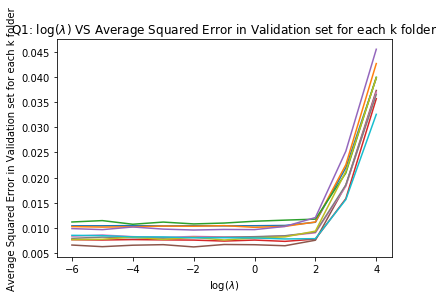

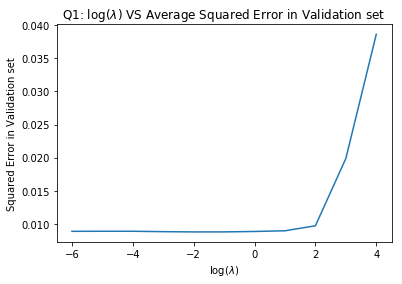

In [94]:
print "######################### Question 1 ######################"
for i in range(K):
    pl.plot(np.log(np.asarray(regs))/np.log(10), val_loss_all[:, i])
pl.xlabel('log$(\lambda)$')
pl.ylabel('Average Squared Error in Validation set for each k folder')
pl.title('Q1: log$(\lambda)$ VS Average Squared Error in Validation set for each k folder')
pl.show()

pl.plot(np.log(np.asarray(regs))/np.log(10), np.mean(val_loss_all, axis=1))
pl.xlabel('log$(\lambda)$')
pl.ylabel('Squared Error in Validation set')
pl.title('Q1: log$(\lambda)$ VS Average Squared Error in Validation set')
pl.show()

In [95]:
print "######################### Question 2 ######################"
# pl.plot(np.log(np.asarray(regs))/np.log(10), results_test, 'r-')
# pl.xlabel('log$(\lambda)$')
# pl.ylabel('Squared Error in Test Data')
# pl.title('Q2: log$(\lambda)$ VS Squared Error in Test Data')
# pl.show()
test_loss = loss_gradient(X_test, y_test, best_W_all, best_reg, Is_train=False)
print "The best lambda is : ", best_reg
print "The test loss is : ", test_loss

######################### Question 2 ######################
The best lambda is :  0.01
The test loss is :  4.177633034918358


######################### Question 3 ######################


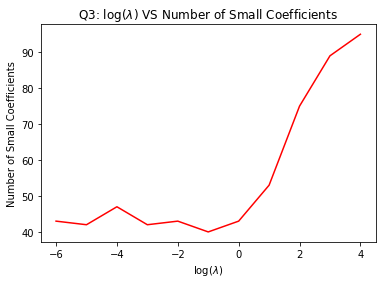

In [96]:
print "######################### Question 3 ######################"
pl.plot(np.log(np.asarray(regs))/np.log(10), num_small_coefs, 'r-')
pl.xlabel('log$(\lambda)$')
pl.ylabel('Number of Small Coefficients')
pl.title('Q3: log$(\lambda)$ VS Number of Small Coefficients')
pl.show()

In [97]:
print "######################### Question 4 ######################"
print "The best test set proformance: lambda = {}, test loss = {}".format(best_reg, best_test_loss)
idx_max = np.argmax(best_W_all[1:])
idx_min = np.argmin(best_W_all[1:])
print "The largest coefficient: \n  name: {}, value: {} ".format(feature_book[int(idx_max)], best_W_all[idx_max, 0])
print "The smallest coefficient: \n  name: {}, value: {} ".format(feature_book[int(idx_min)], best_W_all[idx_min, 0])

######################### Question 4 ######################
The best test set proformance: lambda = 0.01, test loss = 4.17763303492
The largest coefficient: 
  name: PctIlleg, value: -0.0194008910324 
The smallest coefficient: 
  name: PctKids2Par, value: -0.0104024894802 
